# Downloading, pre-processing and running cNMF on Zepp et. al 2021 data
1. Obtaining the AnnData object and complementary metadata

2. filtering genes, selecting joint highly variable genes (HVGs) and showing key statistics
3. Splitting the dataset by developmental stage, and selecting HVG per stage
3. Running consensus NMF (cNMF) per stage
4. Selecting parameters for the cNMF 



In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
from importlib import reload

import sys
import os
import time

import numpy as np
import pandas as pd
from scipy import sparse
import scanpy as sc
import matplotlib.pyplot as plt

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf

_utils.cd_proj_home()
print(os.getcwd())
# os.chdir('/cs/labs/mornitzan/yotamcon/gep-dynamics')

/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 2.22 s, sys: 736 ms, total: 2.96 s
Wall time: 7.21 s


### Downloading and loading AnnData object
The adata contains log1p(CP10K) data, so we keep the transformed data in `raw`, and add the original counts as `X`

In [3]:
results_dir = _utils.set_dir('results_zepp')
data_dir = _utils.set_dir('data')
GSE_dir = _utils.set_dir(data_dir.joinpath('GSE149563'))

In [4]:
%%script --no-raise-error false # remove this to run the downloading

# Adata downloaded from https://data-browser.lungmap.net/explore/projects/00f056f2-73ff-43ac-97ff-69ca10e38c89/get-curl-command
# by running this for the adata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22h5ad%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fe42d976a-5137-5422-be32-39008e1d53d7.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config - )
# and then running this for the metadata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22csv%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fed538a08-689b-530d-a661-e1756132b883.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config -)

download_dir = GSE_dir.joinpath('a078a6cb-a72a-305c-80df-cf35aedd01ff')
! mv {download_dir.as_posix()}/* {GSE_dir.as_posix()}
! rmdir {download_dir.as_posix()}

In [5]:
%%time

%time adata = sc.read(GSE_dir.joinpath('JZ_Mouse_TimeSeries.h5ad'))
metadata = pd.read_csv(GSE_dir.joinpath('AllTimePoints_metadata.csv'), index_col=0)

adata.obs['celltype'] = metadata.var_celltype
adata.obs['compartment'] = metadata.var_compartment

adata.raw = adata
adata.X = (sparse.csc_matrix(adata.obs.n_molecules.values[:, None] / 10_000).multiply(adata.X.expm1())).rint()
adata

CPU times: user 5.48 s, sys: 0 ns, total: 5.48 s
Wall time: 13.5 s
CPU times: user 12.5 s, sys: 51 µs, total: 12.5 s
Wall time: 20.6 s


AnnData object with n_obs × n_vars = 67794 × 18129
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment'
    var: 'name'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [6]:
adata.obs.development_stage = adata.obs.development_stage.cat.rename_categories(
    {'Adult': 'P42', 'E12.5': 'E12', 'E15.5': 'E15', 'E17.5': 'E17'}).cat.reorder_categories(
    ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42'])

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


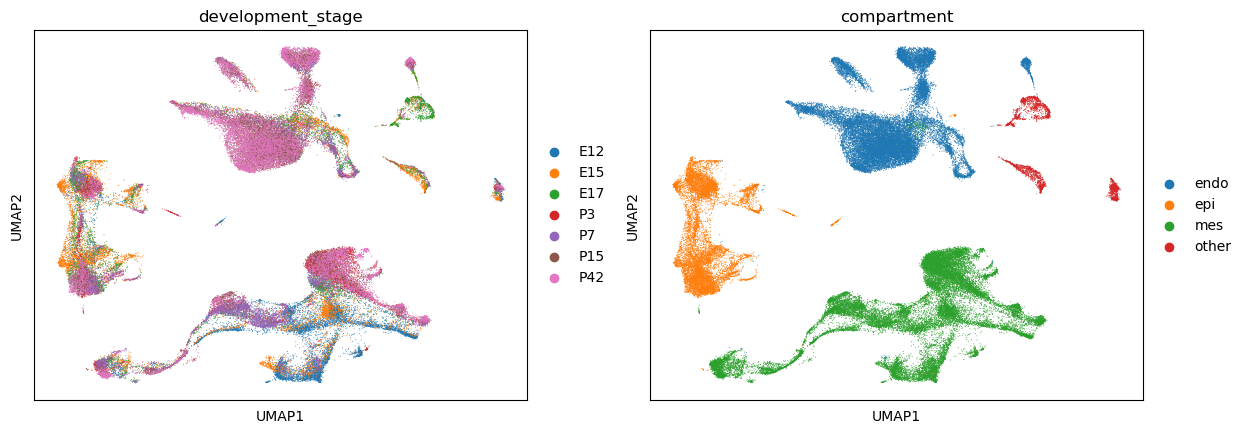

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


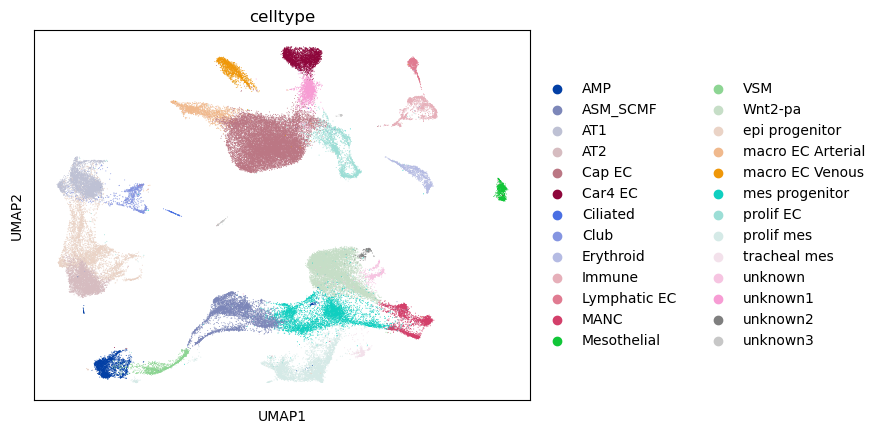

In [24]:
sc.pl.umap(adata, color=['development_stage', 'compartment'])
sc.pl.umap(adata, color=['celltype'])

adata.uns['development_stage_colors_dict'] = dict(zip(adata.obs['development_stage'].cat.categories, adata.uns['development_stage_colors']))
adata.uns['compartment_colors_dict'] = dict(zip(adata.obs['compartment'].cat.categories, adata.uns['compartment_colors']))
adata.uns['celltype_colors_dict'] = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))

In [25]:
pd.crosstab(adata.obs.development_stage, adata.obs.compartment)

compartment,endo,epi,mes,other
development_stage,,,,
E12,133,679,7752,403
E15,1095,3676,2516,1017
E17,1681,2573,2012,937
P3,2991,2196,5063,141
P7,3992,1632,4433,140
P15,7345,739,2327,108
P42,7646,1041,3404,122


In [26]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage,E12,E15,E17,P3,P7,P15,P42
celltype,,,,,,,
AMP,178,224,317,327,356,189,376
ASM_SCMF,732,227,417,678,1936,378,263
AT1,125,711,779,865,344,248,355
AT2,54,243,739,815,811,432,517
Cap EC,55,557,783,1517,2073,5239,4875
Car4 EC,0,0,30,346,430,908,1078
Ciliated,0,0,5,61,5,2,4
Club,112,418,157,94,72,26,54
Erythroid,53,601,114,18,70,65,7


In [27]:
pd.crosstab(adata.obs.celltype, adata.obs.compartment)

compartment,endo,epi,mes,other
celltype,,,,
AMP,0,0,1967,0
ASM_SCMF,0,0,4631,0
AT1,0,3427,0,0
AT2,0,3611,0,0
Cap EC,15099,0,0,0
Car4 EC,2792,0,0,0
Ciliated,0,77,0,0
Club,0,933,0,0
Erythroid,0,0,0,928


### Filter genes and plot basic statistics

In [7]:
%%time

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 1000))

# getting general statistics for counts abundance
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_cells(adata, min_genes=0)

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)
adata

CPU times: user 7.89 s, sys: 2.8 s, total: 10.7 s
Wall time: 10.6 s


AnnData object with n_obs × n_vars = 67794 × 16184
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

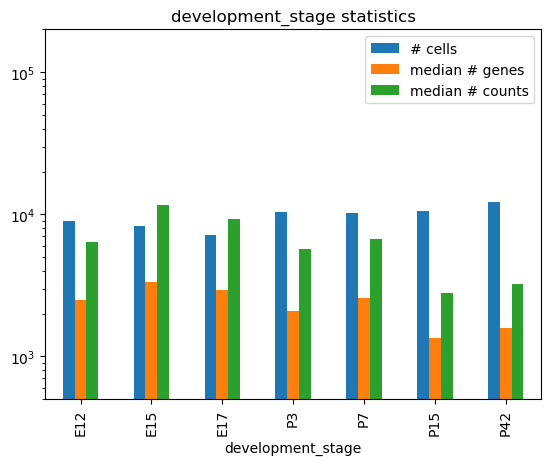

In [29]:
column_of_interest = 'development_stage'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((5e2, 2e5)))
plt.show()
del column_of_interest, stats_df

In [14]:
_utils.joint_hvg_across_stages(adata, obs_category_key='development_stage')
adata.var


,name,n_cells,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,development_stage_max_var_norm,joint_highly_variable
Sox17,Sox17,18167,41543.0,True,954.0,0.612783,2.185803,1.911305,6.756488,True
Mrpl15,Mrpl15,22890,36466.0,False,NaN,0.537894,0.938963,0.989088,0.989088,False
Lypla1,Lypla1,18216,23039.0,False,NaN,0.339838,0.400800,0.778880,0.927863,False
Tcea1,Tcea1,29410,45005.0,False,NaN,0.663849,0.906531,0.705129,0.918159,False
Atp6v1h,Atp6v1h,13201,15381.0,False,NaN,0.226878,0.249574,0.790966,0.928798,False
...,...,...,...,...,...,...,...,...,...,...
Gm12185,Gm12185,159,160.0,False,NaN,0.002360,0.002384,0.855554,0.904272,False
Olfr56,Olfr56,227,237.0,False,NaN,0.003496,0.003808,0.879820,0.970031,False
Slc22a12,Slc22a12,68,70.0,False,NaN,0.001033,0.001090,1.022095,1.022095,False
Ido1,Ido1,80,81.0,False,NaN,0.001195,0.001223,0.964506,0.964506,False


### Splitting the adata by "development_stage", and creating a normalized variance layer

In [30]:
%%time

stages = adata.obs.development_stage.cat.categories
split_adatas_dir = _utils.set_dir(results_dir.joinpath('split_adatas'))

for stage in stages:
    print(f'working on stage {stage}')
    if not split_adatas_dir.joinpath(f'{stage}.h5ad').exists():
        tmp = adata[adata.obs.development_stage == stage].copy()

        tmp.uns['name'] = f'{stage}'   # full name
        tmp.uns['sname'] = f'{stage}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        # calculating per sample HVGs
        sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{stage}.h5ad'))

        del tmp

working on stage E12
working on stage E15
working on stage E17
working on stage P3
working on stage P7
working on stage P15
working on stage P42
CPU times: user 1.01 ms, sys: 0 ns, total: 1.01 ms
Wall time: 2.85 ms


### Running multiple NMF iterations

In [106]:
%%time

cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))

ks = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for stage in stages:
    print(f'Starting on {stage}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{stage}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, stage)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.highly_variable].toarray().astype(np.float32), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=100, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE,
                                                        'beta_loss': 'kullback-leibler'})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X
    


Starting on E12
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Starting on E15
Combining factorizations for 

In [115]:
%%time
for stage in stages:
    print(f'Starting on {stage}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, stage)
    for thresh in [0.5, 0.4, 0.3]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=500,
                                  close_fig=True, show_clustering=True, gpu=True)
    


Starting on E12, time is 10:28:13
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on E15, time is 10:38:48
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on E17, time is 10:48:39
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on P3, time is 10:58:05
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on P7, time is 11:08:05
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on P15, time is 11:18:56
working on threshold 0.5
working on threshold 0.4
working on threshold 0.4
working on threshold 0.3
CPU times: user 3h 5min 37s, sys: 5h 42min 26s, total: 8h 48min 4s
Wall time: 1h 13min 23s


### Selecting the decomposition rank utilizing K-selection plots and PCA variance explained

In [80]:
%%time
df_var = pd.DataFrame()
df_cumulative_var = pd.DataFrame()

n_components = 50

for stage in stages:
    
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{stage}.h5ad'))
    
    a, b, c, d, = sc.tl.pca(tmp.X[:, tmp.var.highly_variable], n_comps=n_components, return_info=True)

    df_var[f'{stage}'] = c*100
    df_cumulative_var[f'{stage}'] = c.cumsum()*100

CPU times: user 216 ms, sys: 305 ms, total: 521 ms
Wall time: 17.8 s
CPU times: user 339 ms, sys: 1.18 s, total: 1.52 s
Wall time: 20.1 s
CPU times: user 332 ms, sys: 1.07 s, total: 1.4 s
Wall time: 20.7 s
CPU times: user 337 ms, sys: 1.08 s, total: 1.41 s
Wall time: 18.5 s
CPU times: user 398 ms, sys: 1.15 s, total: 1.54 s
Wall time: 25.2 s
CPU times: user 290 ms, sys: 1 s, total: 1.29 s
Wall time: 19.3 s
CPU times: user 343 ms, sys: 1.07 s, total: 1.41 s
Wall time: 21.5 s
CPU times: user 22.8 s, sys: 1min 18s, total: 1min 40s
Wall time: 2min 32s


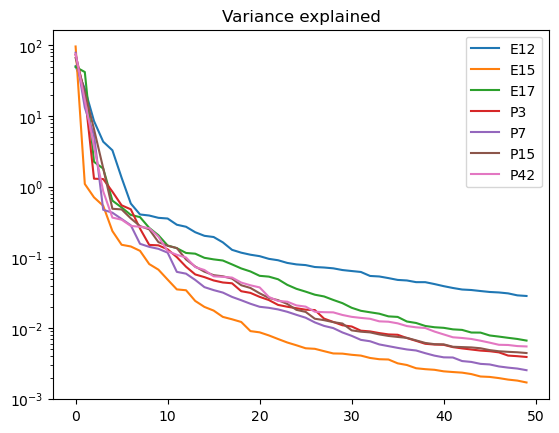

In [100]:
plt.plot(range(50), df_var, label=df_var.columns)
plt.title('Variance explained')
plt.legend()
plt.yscale('log')
plt.show()

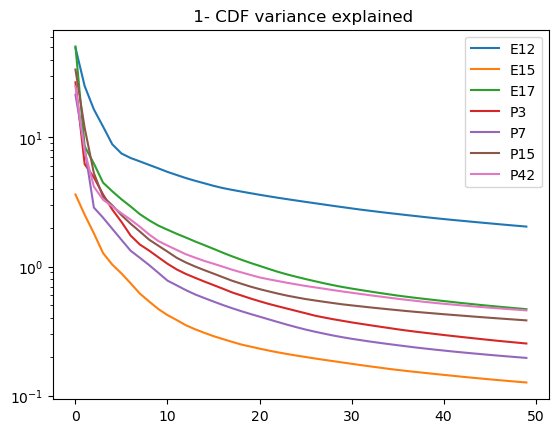

In [99]:
plt.plot(df_cumulative_var.index, 100-df_cumulative_var, label=df_var.columns)
plt.yscale('log')
plt.title(f' 1- CDF variance explained')
plt.legend()
plt.show()

In [103]:
%%time

selected_cnmf_params = {
    'E12': (16, 0.4),  # 
    'E15': (18, 0.4),  # 
    'E17': (15, 0.4),    # 
    'P3': (16, 0.5),    # rank 16 has a split that improves loss and stability
    'P7': (18, 0.4),   # 
    'P15': (13, 0.4),  # 
    'P42': (13, 0.4)}   # 

split_adatas = {}

for stage, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on {stage} with k={k} and threshold={threshold}')
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{stage}.h5ad'))

    c_object = cnmf.cNMF(cnmf_dir, stage)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after TPM normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    split_adatas[stage] = tmp

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{stage}_GEPs.h5ad'))

Working on E12 with k=16 and threshold=0.4
CPU times: user 334 ms, sys: 208 ms, total: 541 ms
Wall time: 9.88 s
Updating W based on consensus spectra
beta 1 loss = 5605611.5, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 5561871.5, # iterations was 270
Working on E15 with k=18 and threshold=0.4
CPU times: user 379 ms, sys: 252 ms, total: 631 ms
Wall time: 8.11 s
Updating W based on consensus spectra
beta 1 loss = 4479138.0, # iterations was 80
Refitting W, H based on consensus
beta 1 loss = 4451855.5, # iterations was 210
Working on E17 with k=15 and threshold=0.4
CPU times: user 325 ms, sys: 186 ms, total: 511 ms
Wall time: 6.77 s
Updating W based on consensus spectra
beta 1 loss = 3989173.75, # iterations was 80
Refitting W, H based on consensus
beta 1 loss = 3894702.25, # iterations was 270
Working on P3 with k=16 and threshold=0.5
CPU times: user 334 ms, sys: 223 ms, total: 557 ms
Wall time: 10.7 s
Updating W based on consensus spectra
beta 1 loss = 5441049.0

### Examening results

In [107]:
%%time

split_adatas = {}
for stage in stages:
    split_adatas[stage] = sc.read_h5ad(split_adatas_dir.joinpath(f'{stage}_GEPs.h5ad'))

CPU times: user 2.52 s, sys: 4.66 s, total: 7.18 s
Wall time: 48.9 s


In [108]:
for stage in stages:
    print(stage)
    s = split_adatas[stage].obsm['usages_norm'].sum(axis=0)
    with np.printoptions(precision=2, suppress=False):
        print(s * 100 / s.sum())

E12
[ 8.3   1.58  5.68  1.75  4.85  2.94  5.57  8.59  8.54 13.29  1.63 17.28
 10.06  0.9   7.08  1.96]
E15
[ 4.82  5.99 10.31  2.16  3.52  4.91  1.39 16.78  0.71  1.17  2.77  3.05
  1.63  5.16 15.28  0.7   2.45 17.21]
E17
[12.67  6.71 12.54 17.11  5.42  9.13  4.08  9.93  1.91  1.08  2.94  2.13
  9.36  2.74  2.23]
P3
[10.02  9.31 29.42  3.56  6.22  1.01  1.43  7.13  2.97 16.97  3.53  2.2
  0.76  0.61  3.67  1.2 ]
P7
[ 4.59  9.65  3.88  3.64  6.73  1.1   3.81 20.49 10.   14.22  2.83  7.08
  1.04  2.6   2.84  3.47  1.04  0.99]
P15
[14.21  5.71  4.35 11.48 37.6   3.34  1.75  2.53  3.46  1.42  5.57  4.22
  4.37]
P42
[ 5.34 17.22 11.22  4.39 34.64  4.15  1.16  3.45  4.92  1.51  6.38  1.02
  4.6 ]


In [ ]:
# Plotting normalized usages clustermap
for time in times:
    tmp = split_adatas[time]
    sname = tmp.uns["sname"]
    k = tmp.obsm["usages"].shape[1]

    un_sns = _utils.plot_usages_norm_clustermaps(tmp, show=True)
    un_sns.savefig(results_dir.joinpath(
        sname, f'{sname}.usages_norm.k_{k}.png'),
        dpi=180, bbox_inches='tight')
    plt.close(un_sns.fig)

    _utils.plot_usages_norm_violin(
        tmp, 'clusterK12', save_path=results_dir.joinpath(
            sname, f'{sname}_norm_usage_per_lineage_k_{k}.png'))




## ToDo - plot all programs on phate
## ToDo - consider adding "main program" per cell and plot it on joint tsne and phate

In [ ]:
for time in times:
    tmp = split_adatas[time]
    plt.scatter(tmp.obsm['X_phate'][:, 0], tmp.obsm['X_phate'][:, 1], c=tmp.obsm['usages_norm'][:, 0])
    plt.title(f'{tmp.uns["name"]} Program 0 on Phate coordinates')
    plt.show()
    plt.close()

In [ ]:

# sub-setting the genes:
mutual_hvg = list(set().union(*[tmp.var[tmp.var.highly_variable].index \
                          for time, tmp in split_adatas.items()]))
mutual_hvg = list(set(mutual_hvg).intersection(*[tmp.var[tmp.var.highly_variable].index \
                          for time, tmp in split_adatas.items()]))
# mutual_hvg = adata.var[adata.var.highly_variable].index

concatenated_spectras = pd.concat([
    tmp.varm['usage_coefs'].loc[mutual_hvg].copy() for time, tmp in split_adatas.items()], axis=1)

n_genes, n_programs = concatenated_spectras.shape

pearson_corr = np.corrcoef(concatenated_spectras.T)

# cosine figure
fig, ax = plt.subplots(figsize=(4 + n_programs * 0.43, 4 + n_programs * 0.41))

_utils.heatmap_with_numbers(
    pearson_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title('Pearson correlation',
             size=25, y=1.05, x=0.43)

fig.savefig(results_dir.joinpath('correlation_pearson.png'),
            dpi=180, bbox_inches='tight')
plt.close(fig)


# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(pearson_corr[np.triu_indices_from(pearson_corr, k=1)],
         bins=np.linspace(-1, 1, 41))
ax.set_title('Pearson correlation distribution')
plt.show()

fig.savefig(results_dir.joinpath('correlation_histogtam_pearson.png'),
            dpi=180, bbox_inches='tight')

plt.close(fig)

# 3.1b Calculating spearman correlation between usages coefficient

from scipy.stats import rankdata
N_COMPARED_RANKED = 1000

ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)

ranked_coefs[ranked_coefs > N_COMPARED_RANKED] = N_COMPARED_RANKED

spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

# spearman figure
fig, ax = plt.subplots(figsize=(4 + ranked_coefs.shape[1] * 0.43,
                                4 + ranked_coefs.shape[1] * 0.41))

_utils.heatmap_with_numbers(
    spearman_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title(f'{N_COMPARED_RANKED}-Truncated Spearman Correlation',
             size=25, y=1.05, x=0.43)

fig.savefig(results_dir.joinpath(
    f'correlation_spearman_{N_COMPARED_RANKED}_truncated.png'),
    dpi=180, bbox_inches='tight')

plt.close(fig)

# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(spearman_corr[np.triu_indices_from(spearman_corr, k=1)],
         bins=np.linspace(0, 1, 21))
ax.set_title('Spearman Correlation distribution')
plt.show()

fig.savefig(results_dir.joinpath(
    f'correlation_histogtam_spearman_{N_COMPARED_RANKED}_truncated.png'),
    dpi=180, bbox_inches='tight')

plt.close(fig)

In [ ]:

import matplotlib as mpl
import networkx as nx
from scipy.cluster import hierarchy

threshold = 0.2

# maping adata short name to layer number
name_map = {}
for i, time in enumerate(times):
    name_map['t'+time[:2]] = i + 1

ks = [tmp.obsm['usages_norm'].shape[1] for time, tmp in split_adatas.items()]

# adjacency matrix creation and filtering

adj_df = pd.DataFrame(np.round((spearman_corr + pearson_corr) / 2, 2),
                      index=concatenated_spectras.columns,
                      columns=concatenated_spectras.columns)

# order
linkage = hierarchy.linkage(
    adj_df, method='average', metric='euclidean')
prog_order = hierarchy.leaves_list(
    hierarchy.optimal_leaf_ordering(linkage, adj_df))

np.fill_diagonal(adj_df.values, 0)
# adj_df.values[adj_df.values <= 0.0] = 0

# keeping only edges between consecutive layers
for i in range(len(ks) - 2):
    adj_df.values[:np.sum(ks[:i + 1]), np.sum(ks[:i + 2]):] = 0
    adj_df.values[np.sum(ks[:i + 2]):, :np.sum(ks[:i + 1])] = 0

adj_df.values[adj_df.values <= threshold] = 0
print(f'Number of edges={np.count_nonzero(adj_df)}')

# ordering the nodes for display
adj_df = adj_df.iloc[prog_order, prog_order]

# create the graph object
G = nx.from_numpy_array(adj_df.values, create_using=nx.Graph)
nx.relabel_nodes(G, lambda i: adj_df.index[i], copy=False)
nx.set_node_attributes(
    G, {node: name_map[node.split('.')[0]] for node in G.nodes}, name='layer')

# prepare graph for display
layout = nx.multipartite_layout(G, subset_key='layer')

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edge_width = 15 * np.power(weights, 2)  # visual edge emphesis

for layer in {data['layer'] for key, data in G.nodes.data()}:
    nodes = [node for node in G.nodes if name_map[node.split('.')[0]] == layer]

    angles = np.linspace(-np.pi / 4, np.pi / 4, len(nodes))

    for i, node in enumerate(nodes):
        layout[node] = [layer + 2 * np.cos(angles[i]), np.sin(angles[i])]

fig, ax = plt.subplots(1, 1, figsize=(16.4, 19.2), dpi=180)
nx.draw(G, layout, node_size=1500, with_labels=False, edge_color=weights,
        edge_vmin=threshold, edge_vmax=1., width=edge_width, ax=ax)

cmp = mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=threshold, vmax=1))
plt.colorbar(cmp, orientation='horizontal', cax=fig.add_subplot(15, 5, 71))

# change color of layers
for time, tmp in split_adatas.items():
    nx.draw_networkx_nodes(
        G, layout, node_color=adata.uns['timesimple_colors_dict'][time],
        node_size=1400, nodelist=[f'{tmp.uns["sname"]}.p{i}' for i in range(
            tmp.obsm['usages'].shape[1])], ax=ax)
nx.draw_networkx_labels(G, layout, font_size=11, ax=ax)

ax.set_title(f'Timepoint correlation graph, correlation threshold={threshold}',
             {'fontsize': 25})
plt.show()


fig.savefig(results_dir.joinpath(
    f'correlations_graph_threshold_{threshold}.png'),
    dpi=180, bbox_inches='tight')

plt.close()

del name_map, G, edges, weights, i, layer, angles, node, nodes
del fig, ax, layout, prog_order

# Epithelial compartment decomposition

### Splitting the adata by "development_stage", retaining only epithelial cells and creating a normalized variance layer

In [123]:
%%time

stages = adata.obs.development_stage.cat.categories
epi_split_adatas_dir = _utils.set_dir(results_dir.joinpath('epi_split_adatas'))

for stage in stages:
    print(f'working on stage {stage}')
    file = epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad')
    
    if not file.exists():
        tmp = adata[adata.obs.development_stage == stage]
        tmp = tmp[(tmp.obs.compartment == 'epi') & (tmp.obs.celltype != 'unknown3')].copy()
                
        tmp.uns['name'] = f'Epi {stage}'   # full name
        tmp.uns['sname'] = f'{stage}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        # calculating per sample HVGs
        sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

        tmp.write_h5ad(file)

        del tmp

working on stage E12
working on stage E15
working on stage E17
working on stage P3
working on stage P7
working on stage P15
working on stage P42
CPU times: user 11.3 s, sys: 2.87 s, total: 14.2 s
Wall time: 32 s


### Running multiple NMF iterations

In [ ]:
%%time

cnmf_dir = _utils.set_dir(results_dir.joinpath('epi_cnmf'))

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for stage in stages:
    print(f'Starting on epithelial {stage}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, stage)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.highly_variable].toarray().astype(np.float32), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=100, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE,
                                                        'beta_loss': 'kullback-leibler'})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X
    


Directory "results_zepp/epi_cnmf" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results_zepp/epi_cnmf
Starting on epithelial E12, time is 14:48:20
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Starting on epithelial E15, time is 14:53:33


In [134]:
%%time
for stage in stages:
    print(f'Starting on {stage}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, stage)
    for thresh in [0.5, 0.4, 0.3]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=500,
                                  close_fig=True, show_clustering=True, gpu=True)

    


Starting on E12, time is 12:14:12
working on threshold 0.5
CPU times: user 1min 36s, sys: 2min 31s, total: 4min 7s
Wall time: 42.8 s


### Selecting the decomposition rank utilizing K-selection plots and PCA variance explained

In [135]:
%%time
df_var = pd.DataFrame()
df_cumulative_var = pd.DataFrame()

n_components = 30

for stage in stages:
    
    %time tmp = sc.read_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad'))
    
    a, b, c, d, = sc.tl.pca(tmp.X[:, tmp.var.highly_variable], n_comps=n_components, return_info=True)

    df_var[f'{stage}'] = c*100
    df_cumulative_var[f'{stage}'] = c.cumsum()*100

CPU times: user 152 ms, sys: 23.5 ms, total: 176 ms
Wall time: 2.09 s
CPU times: user 492 ms, sys: 1.06 s, total: 1.55 s
Wall time: 9.57 s
CPU times: user 371 ms, sys: 961 ms, total: 1.33 s
Wall time: 7.98 s
CPU times: user 312 ms, sys: 941 ms, total: 1.25 s
Wall time: 3.41 s
CPU times: user 309 ms, sys: 964 ms, total: 1.27 s
Wall time: 3.43 s
CPU times: user 289 ms, sys: 892 ms, total: 1.18 s
Wall time: 1.27 s
CPU times: user 276 ms, sys: 974 ms, total: 1.25 s
Wall time: 2.41 s
CPU times: user 6.95 s, sys: 21.7 s, total: 28.6 s
Wall time: 32.9 s


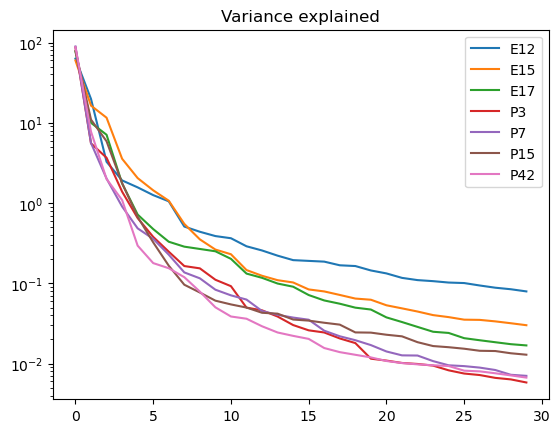

In [138]:
plt.plot(range(len(df_var)), df_var, label=df_var.columns)
plt.title('Variance explained')
plt.legend()
plt.yscale('log')
plt.show()

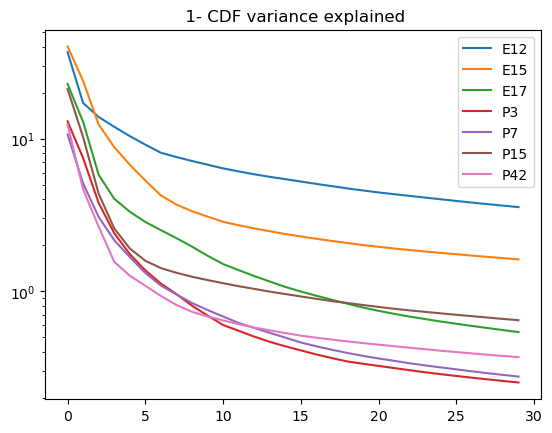

In [139]:
plt.plot(df_cumulative_var.index, 100-df_cumulative_var, label=df_var.columns)
plt.yscale('log')
plt.title(f' 1- CDF variance explained')
plt.legend()
plt.show()

In [140]:
%%time

selected_cnmf_params = {
    'E12': (7, 0.5),  # 
    'E15': (8, 0.5),  # 
    'E17': (10, 0.5),   # 
    'P3': (9, 0.5),    # 
    'P7': (8, 0.5),   # 
    'P15': (5, 0.5),  # 
    'P42': (5, 0.5)}   # 

epi_split_adatas = {}

for stage, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on epi {stage} with k={k} and threshold={threshold}')
    %time tmp = sc.read_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad'))

    c_object = cnmf.cNMF(cnmf_dir, stage)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after TPM normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    epi_split_adatas[stage] = tmp

    tmp.write_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}_GEPs.h5ad'))

Working on epi E12 with k=7 and threshold=0.5
CPU times: user 158 ms, sys: 24.5 ms, total: 183 ms
Wall time: 1.32 s
Updating W based on consensus spectra
beta 1 loss = 574924.8125, # iterations was 150
Refitting W, H based on consensus
beta 1 loss = 566220.5625, # iterations was 420
Working on epi E15 with k=8 and threshold=0.5
CPU times: user 351 ms, sys: 149 ms, total: 500 ms
Wall time: 6.65 s
Updating W based on consensus spectra
beta 1 loss = 3216023.5, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 3160945.75, # iterations was 250
Working on epi E17 with k=10 and threshold=0.5
CPU times: user 264 ms, sys: 86.9 ms, total: 351 ms
Wall time: 5.47 s
Updating W based on consensus spectra
beta 1 loss = 1933602.625, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 1920770.875, # iterations was 180
Working on epi P3 with k=9 and threshold=0.5
CPU times: user 208 ms, sys: 45.7 ms, total: 253 ms
Wall time: 2.78 s
Updating W based on consensus spectr

In [13]:
epidata.obsm_keys()

['X_pca', 'X_tsne', 'X_umap', 'usages', 'usages_norm']

In [16]:
stages = ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42']
decomposition_images = _utils.set_dir(results_dir.joinpath("epi_split_adatas", "images"))


for stage in stages:
    epidata = sc.read_h5ad(results_dir.joinpath("epi_split_adatas", f"epi_{stage}_GEPs.h5ad"))
    
    # UMAP
    um = sc.pl.umap(epidata, color='celltype', s=10, return_fig=True, title=f'{stage} epithelial')
    plt.tight_layout()
    um.savefig(decomposition_images.joinpath(f"epi_{stage}_umap_celltype.png"), dpi=300)
    plt.close(um)

    # usages clustermap
    un_sns = _utils.plot_usages_norm_clustermaps(
        epidata, title=f'{stage}', show=False,sns_clustermap_params={
            'row_colors': epidata.obs['celltype'].map(epidata.uns['celltype_colors_dict'])})
    un_sns.savefig(decomposition_images.joinpath(f"epi_{stage}_usages_norm.png"),
                   dpi=180, bbox_inches='tight')
    plt.close(un_sns.fig)

    # usages violin plot
    _utils.plot_usages_norm_violin(
        epidata, 'celltype', save_path=decomposition_images.joinpath(
            f'epi_{stage}_norm_usage_per_lineage.png'))

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plot